# Visualizing intermediate activations

In [1]:
import numpy as np
from keras import models
from keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
import os

cur_dir = os.getcwd()

In [3]:
model = models.load_model(os.path.join(cur_dir, 'cats_and_dogs_small_1.h5'))

In [4]:
img = load_img('input/cat.jpg', target_size=(150, 150))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

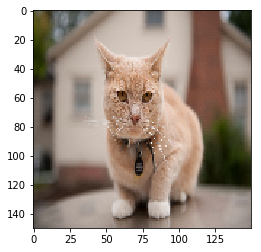

In [5]:
plt.imshow(img_tensor[0])
plt.show()

In [6]:
layers_output = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.inputs, outputs=layers_output)

In [7]:
activations = activation_model.predict(img_tensor)

In [8]:
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[:8]]

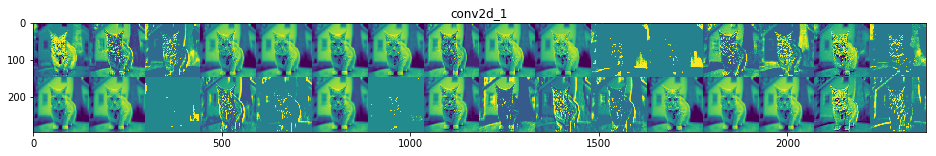

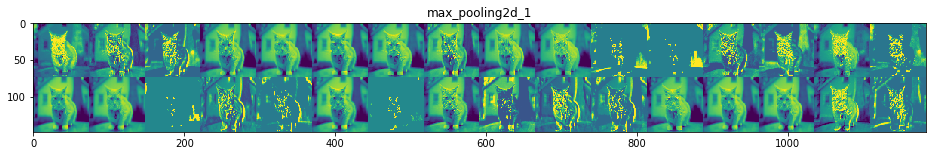

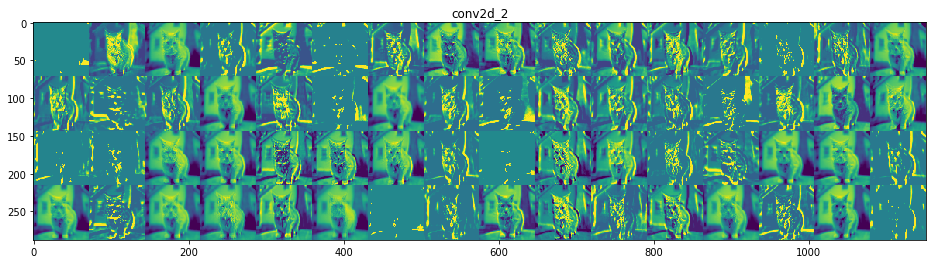

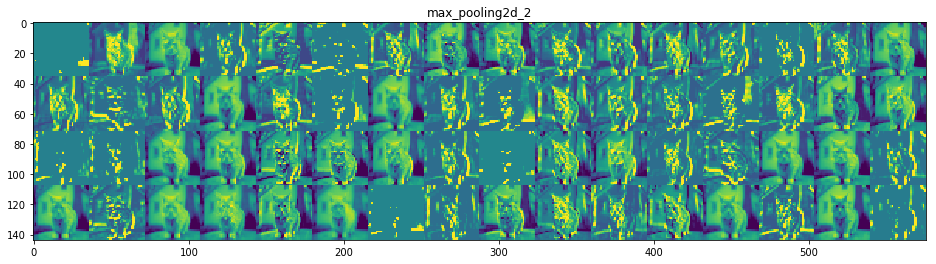

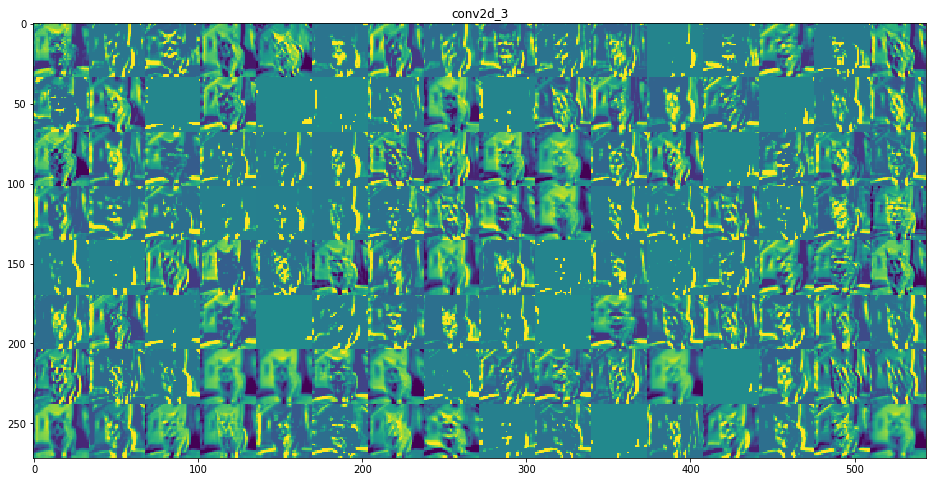

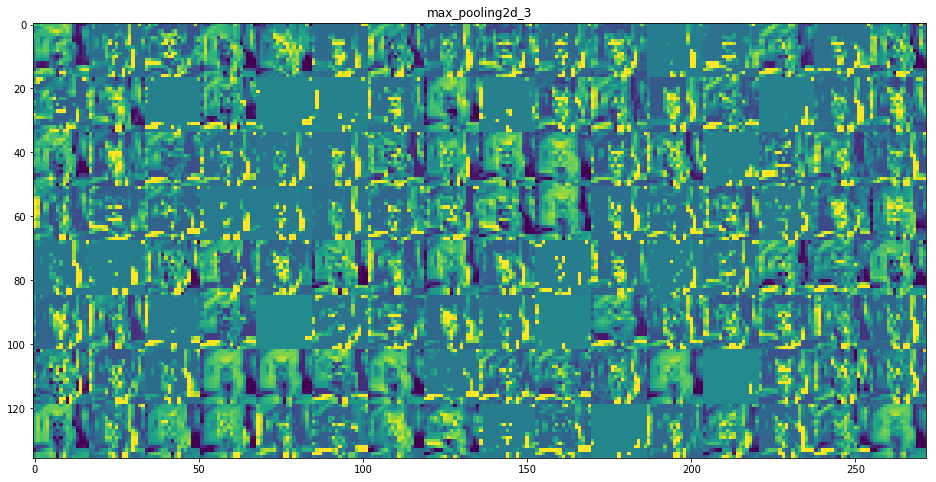

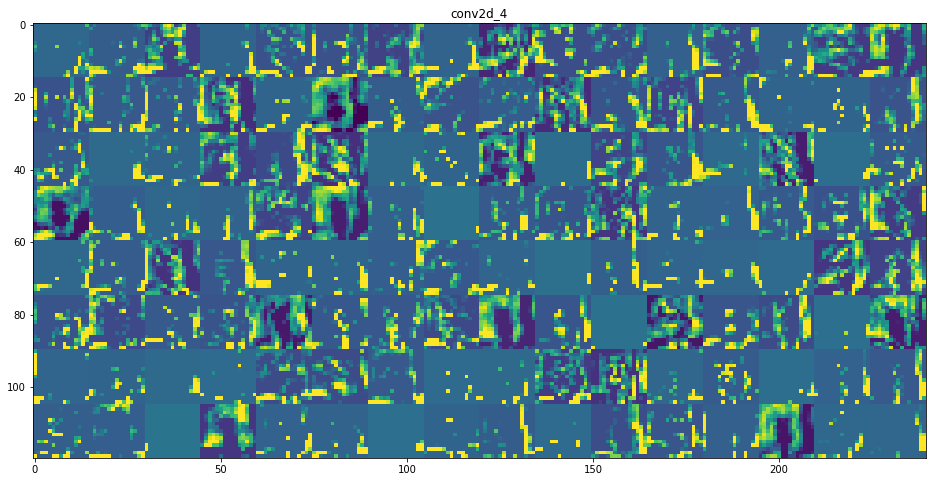

/home/anton/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


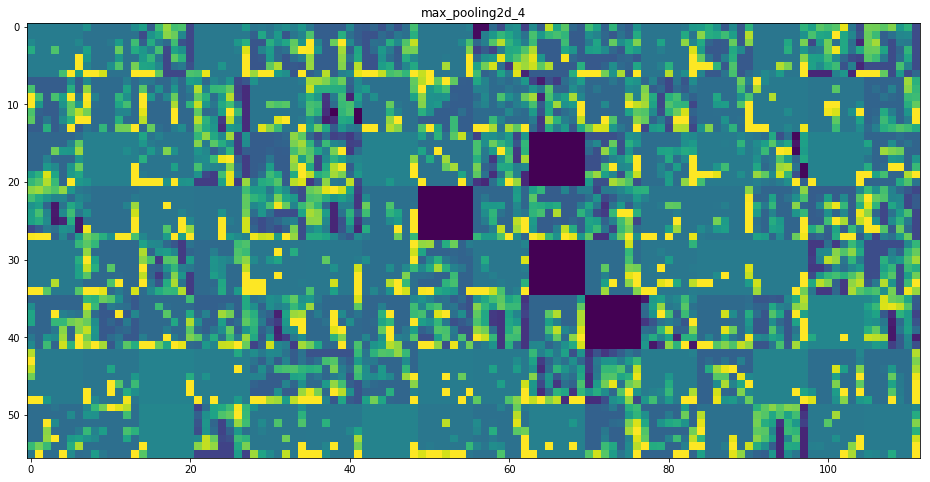

In [9]:
images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col + 1) * size,
            row * size: (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

# Visualizing convnet filters

In [10]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

In [11]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
#     x *= 255
#     x = np.clip(x, 0, 255).astype('uint8')
    return x

In [12]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3))# * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if i == 39:
            print(layer_name, filter_index, loss_value)
    img = input_img_data[0]
    return deprocess_image(img)

  0%|          | 0/4 [00:00<?, ?it/s]

block1_conv1 0 89.23352
block1_conv1 8 212.83789
block1_conv1 16 135.94255
block1_conv1 24 52.876873
block1_conv1 32 70.49074
block1_conv1 40 87.27428
block1_conv1 48 65.38926
block1_conv1 56 62.295162
block1_conv1 1 133.9209
block1_conv1 9 85.769
block1_conv1 17 35.17868
block1_conv1 25 139.42029
block1_conv1 33 75.09122
block1_conv1 41 83.30008
block1_conv1 49 85.061455
block1_conv1 57 100.15374
block1_conv1 2 27.671303
block1_conv1 10 94.45989
block1_conv1 18 174.9741
block1_conv1 26 82.223465
block1_conv1 34 71.86116
block1_conv1 42 46.04986
block1_conv1 50 119.352554
block1_conv1 58 82.42495
block1_conv1 3 80.27548
block1_conv1 11 65.41683
block1_conv1 19 139.4814
block1_conv1 27 135.54884
block1_conv1 35 69.97647
block1_conv1 43 64.948006
block1_conv1 51 101.36343
block1_conv1 59 178.83688
block1_conv1 4 47.56228
block1_conv1 12 247.19815
block1_conv1 20 83.02056
block1_conv1 28 65.90252
block1_conv1 36 120.30075
block1_conv1 44 52.788963
block1_conv1 52 93.349434
block1_conv1 60

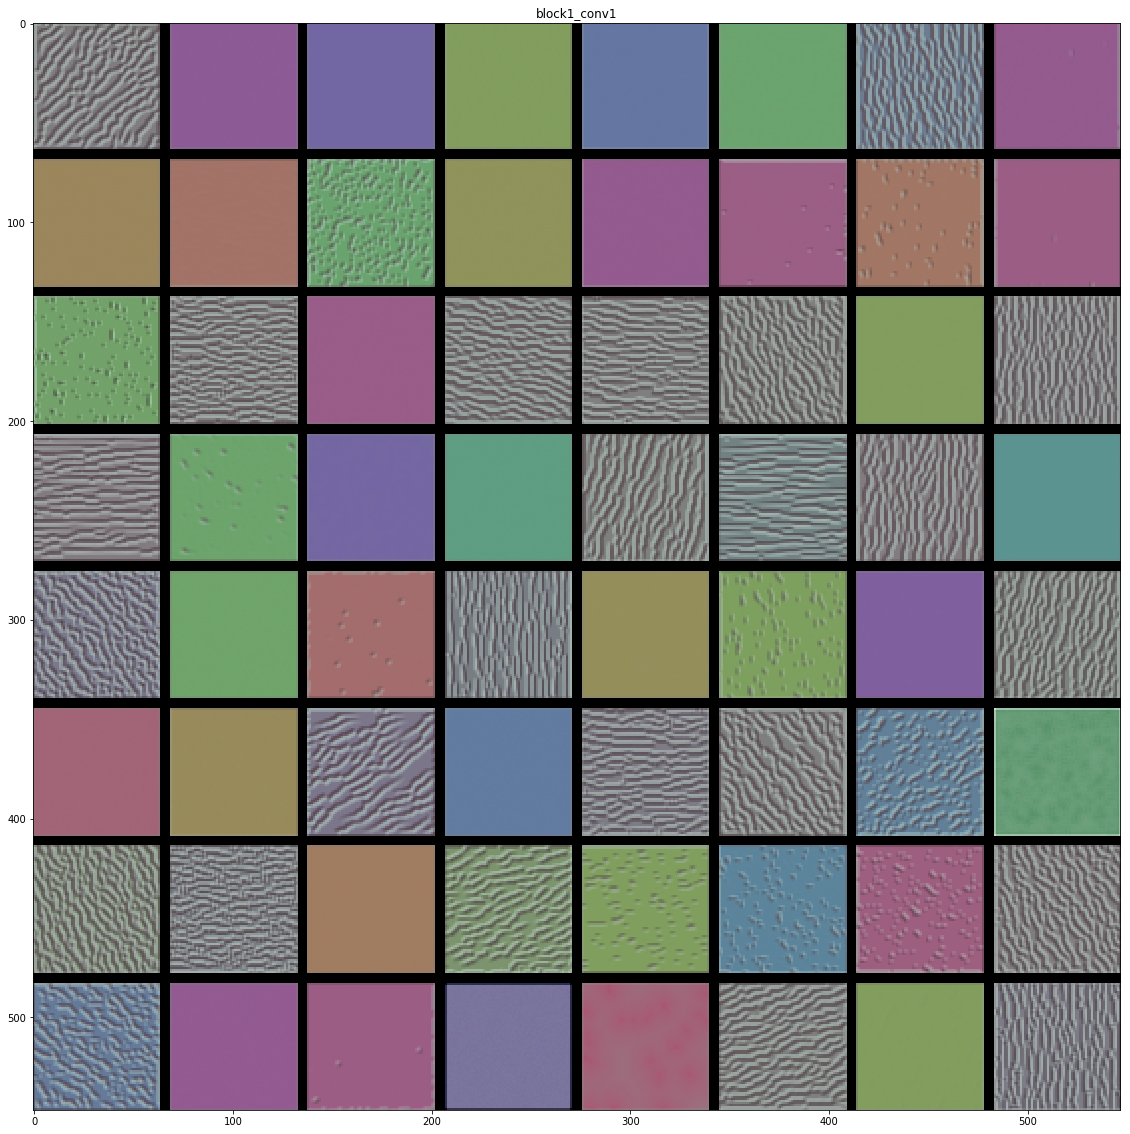

 25%|██▌       | 1/4 [00:10<00:32, 10.86s/it]

block2_conv1 0 0.0
block2_conv1 8 659.6658
block2_conv1 16 524.44965
block2_conv1 24 688.3885
block2_conv1 32 1523.7388
block2_conv1 40 190.15427
block2_conv1 48 614.57635
block2_conv1 56 1530.8987
block2_conv1 1 535.61255
block2_conv1 9 551.0304
block2_conv1 17 749.23456
block2_conv1 25 1159.3368
block2_conv1 33 697.4102
block2_conv1 41 894.9883
block2_conv1 49 304.89722
block2_conv1 57 546.16815
block2_conv1 2 1049.76
block2_conv1 10 561.35864
block2_conv1 18 1232.5667
block2_conv1 26 1161.046
block2_conv1 34 1092.1095
block2_conv1 42 837.2351
block2_conv1 50 309.68668
block2_conv1 58 891.14514
block2_conv1 3 1340.9797
block2_conv1 11 612.2788
block2_conv1 19 727.712
block2_conv1 27 845.4611
block2_conv1 35 0.0
block2_conv1 43 24.402624
block2_conv1 51 65.365715
block2_conv1 59 940.70557
block2_conv1 4 725.6058
block2_conv1 12 1363.2429
block2_conv1 20 1140.9753
block2_conv1 28 893.2673
block2_conv1 36 801.23267
block2_conv1 44 650.7232
block2_conv1 52 460.26706
block2_conv1 60 0.0
b

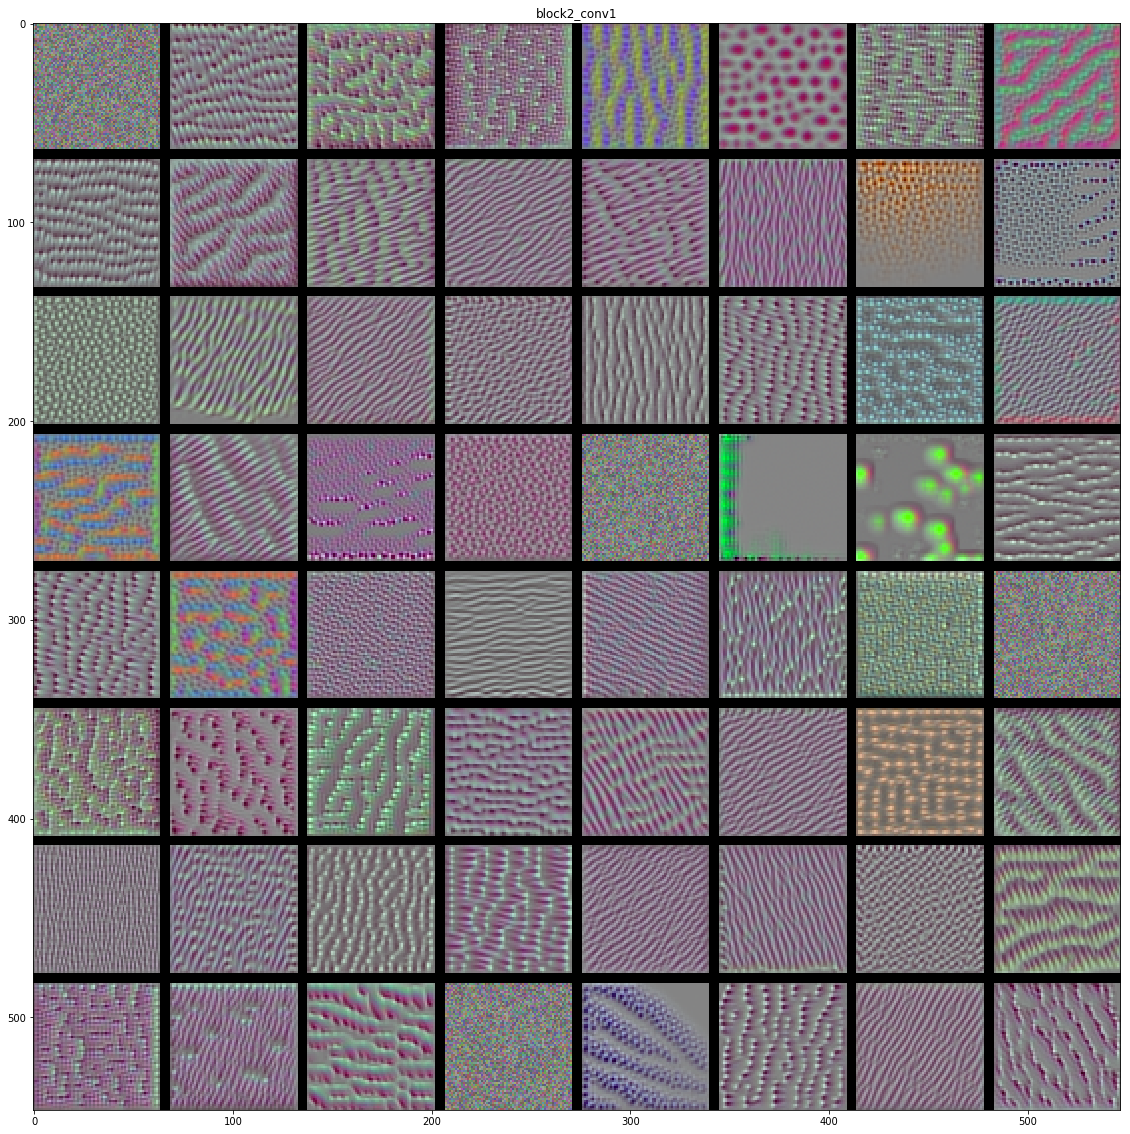

 50%|█████     | 2/4 [00:34<00:29, 14.56s/it]

block3_conv1 0 3672.3804
block3_conv1 8 2221.2664
block3_conv1 16 1478.2777
block3_conv1 24 0.0
block3_conv1 32 3117.2322
block3_conv1 40 3142.5012
block3_conv1 48 4213.613
block3_conv1 56 3516.7407
block3_conv1 1 566.4158
block3_conv1 9 3478.855
block3_conv1 17 2393.8457
block3_conv1 25 4546.2676
block3_conv1 33 8608.865
block3_conv1 41 5147.7397
block3_conv1 49 4483.202
block3_conv1 57 1443.6212
block3_conv1 2 5170.52
block3_conv1 10 2755.3103
block3_conv1 18 4265.5146
block3_conv1 26 3366.268
block3_conv1 34 3855.685
block3_conv1 42 880.6185
block3_conv1 50 5707.794
block3_conv1 58 1923.508
block3_conv1 3 6685.8364
block3_conv1 11 4920.931
block3_conv1 19 3145.0781
block3_conv1 27 3665.0396
block3_conv1 35 4167.3467
block3_conv1 43 2503.8542
block3_conv1 51 2672.3394
block3_conv1 59 2300.1704
block3_conv1 4 5923.614
block3_conv1 12 5074.837
block3_conv1 20 2998.7993
block3_conv1 28 2240.1633
block3_conv1 36 7326.008
block3_conv1 44 1594.383
block3_conv1 52 3428.122
block3_conv1 60 4

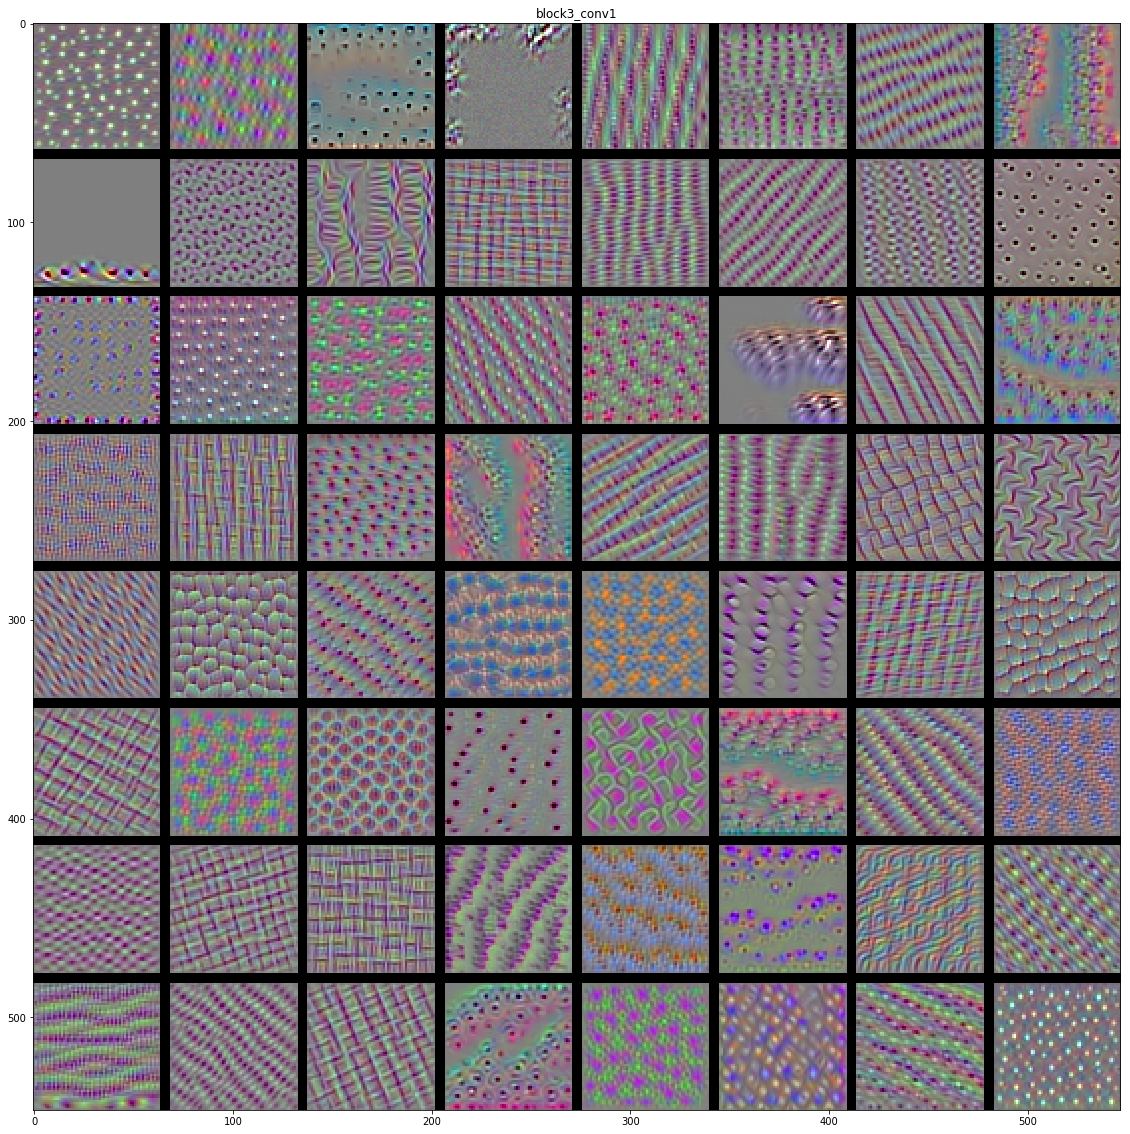

 75%|███████▌  | 3/4 [01:08<00:20, 20.59s/it]

block4_conv1 0 5857.4053
block4_conv1 8 0.0
block4_conv1 16 5755.7715
block4_conv1 24 4548.798
block4_conv1 32 4041.731
block4_conv1 40 5512.0957
block4_conv1 48 3441.1082
block4_conv1 56 5291.5615
block4_conv1 1 4616.25
block4_conv1 9 0.0
block4_conv1 17 4877.383
block4_conv1 25 4388.08
block4_conv1 33 3586.9797
block4_conv1 41 4413.3906
block4_conv1 49 4510.6855
block4_conv1 57 3464.186
block4_conv1 2 2713.745
block4_conv1 10 5451.8477
block4_conv1 18 5082.129
block4_conv1 26 4073.9897
block4_conv1 34 3078.5503
block4_conv1 42 6329.4785
block4_conv1 50 0.0
block4_conv1 58 0.0
block4_conv1 3 5856.748
block4_conv1 11 5125.039
block4_conv1 19 3680.0671
block4_conv1 27 2853.0322
block4_conv1 35 0.0
block4_conv1 43 4062.6843
block4_conv1 51 4855.2715
block4_conv1 59 6148.7266
block4_conv1 4 6954.876
block4_conv1 12 5667.578
block4_conv1 20 5036.0947
block4_conv1 28 8322.318
block4_conv1 36 1423.3767
block4_conv1 44 6757.7573
block4_conv1 52 4211.383
block4_conv1 60 6629.413
block4_conv1 5

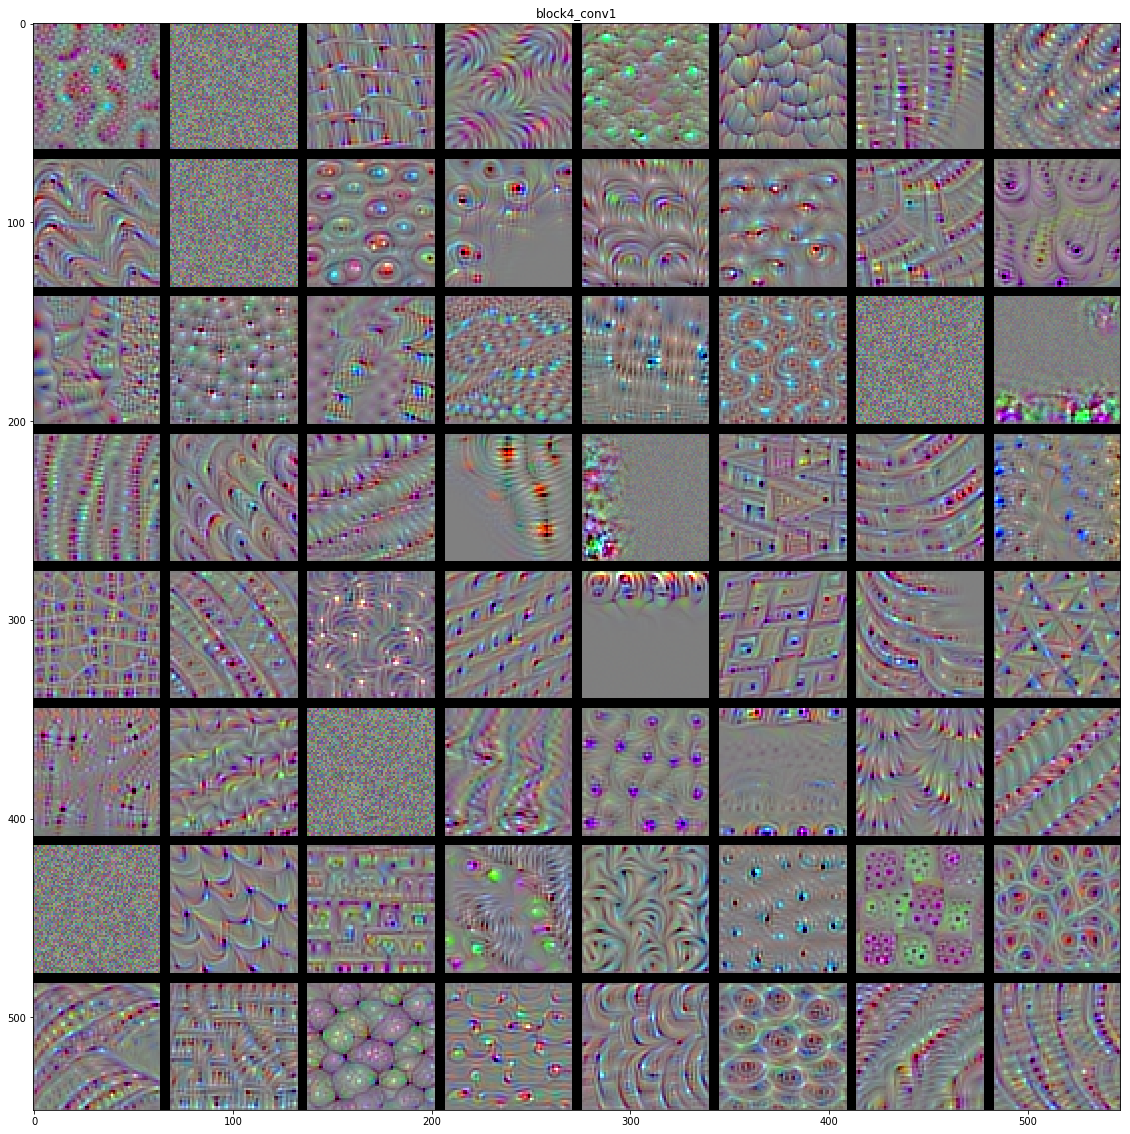

100%|██████████| 4/4 [02:03<00:00, 30.89s/it]


In [13]:
from tqdm import tqdm

for layer_name in tqdm(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']):
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.title(layer_name)

    plt.imshow(results)
    plt.show()

In [14]:
model = models.load_model(os.path.join(cur_dir, 'cats_and_dogs_small_1.h5'))
# from keras import layers

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(150, 150, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [16]:
layer_names = [layer.name for layer in model.layers[:8:2]]

In [17]:
layer_names

['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4']

  0%|          | 0/4 [00:00<?, ?it/s]

conv2d_1 0 32.58539
conv2d_1 1 15.920108
conv2d_1 2 18.852242
conv2d_1 3 24.454336
conv2d_1 4 38.757763
conv2d_1 5 40.456028
conv2d_1 6 37.27807
conv2d_1 7 17.402819
conv2d_1 8 20.213564
conv2d_1 9 54.311687
conv2d_1 10 10.096911
conv2d_1 11 17.63994
conv2d_1 12 14.812374
conv2d_1 13 16.502642
conv2d_1 14 30.638695
conv2d_1 15 15.1526165
conv2d_1 16 38.454815
conv2d_1 17 48.82297
conv2d_1 18 14.57623
conv2d_1 19 16.28853
conv2d_1 20 16.747826
conv2d_1 21 29.309223
conv2d_1 22 14.222127
conv2d_1 23 16.039776
conv2d_1 24 27.663685
conv2d_1 25 13.410901
conv2d_1 26 18.400726
conv2d_1 27 36.427647
conv2d_1 28 67.98921
conv2d_1 29 31.616156
conv2d_1 30 19.322735
conv2d_1 31 15.349559


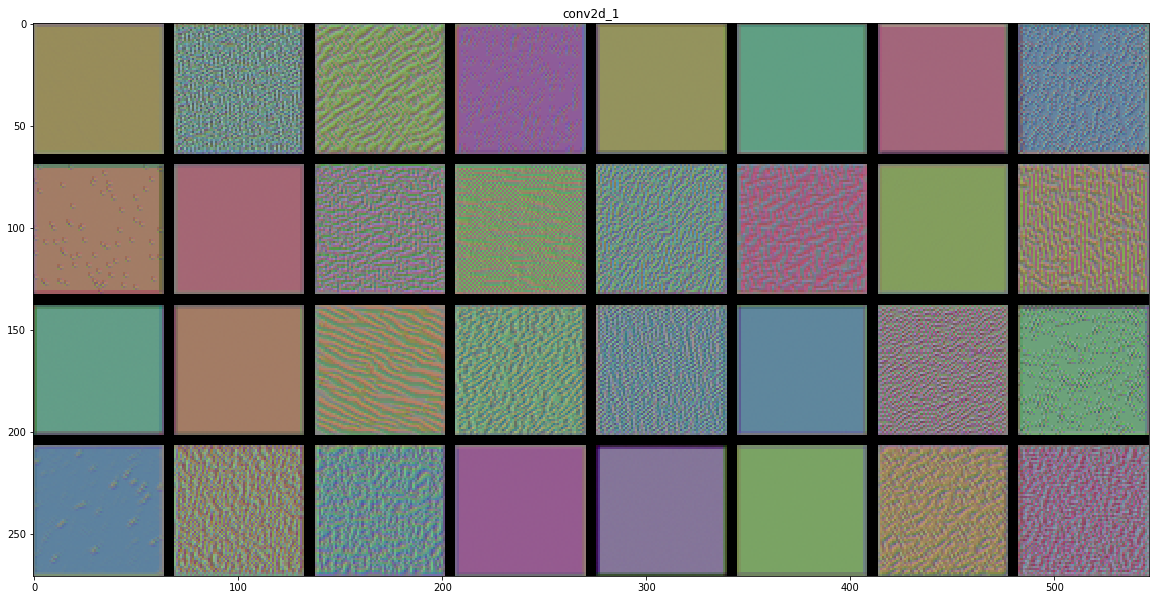

 25%|██▌       | 1/4 [00:26<01:20, 26.93s/it]

conv2d_2 0 43.224964
conv2d_2 1 67.145325
conv2d_2 2 73.75396
conv2d_2 3 87.75005
conv2d_2 4 33.185543
conv2d_2 5 41.787807
conv2d_2 6 34.863533
conv2d_2 7 29.61949
conv2d_2 8 76.550575
conv2d_2 9 69.83272
conv2d_2 10 86.723206
conv2d_2 11 59.428154
conv2d_2 12 66.46443
conv2d_2 13 49.388035
conv2d_2 14 77.23136
conv2d_2 15 53.756092
conv2d_2 16 102.14093
conv2d_2 17 23.316353
conv2d_2 18 28.217783
conv2d_2 19 44.18814
conv2d_2 20 86.32841
conv2d_2 21 61.138325
conv2d_2 22 100.41969
conv2d_2 23 85.26163
conv2d_2 24 55.75004
conv2d_2 25 58.690544
conv2d_2 26 79.42086
conv2d_2 27 88.65406
conv2d_2 28 39.496784
conv2d_2 29 78.12509
conv2d_2 30 60.228485
conv2d_2 31 63.774315


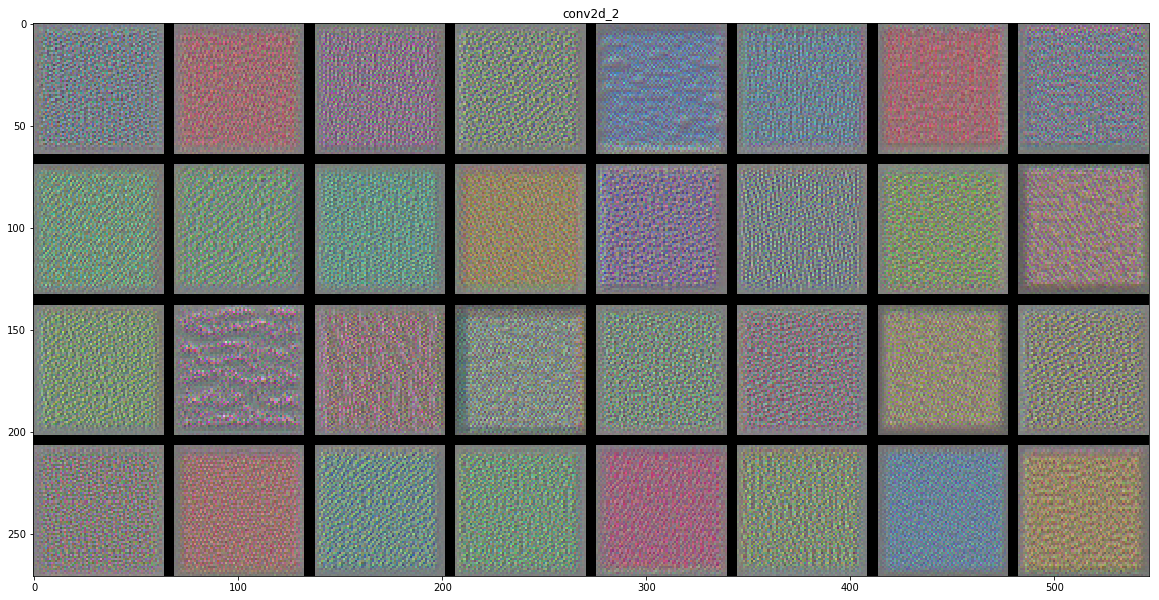

 50%|█████     | 2/4 [00:49<00:51, 25.60s/it]

conv2d_3 0 129.61777
conv2d_3 1 85.29808
conv2d_3 2 75.00707
conv2d_3 3 0.0
conv2d_3 4 0.0
conv2d_3 5 241.68977
conv2d_3 6 0.0
conv2d_3 7 183.68138
conv2d_3 8 112.0502
conv2d_3 9 104.39663
conv2d_3 10 197.14264
conv2d_3 11 0.0
conv2d_3 12 85.00774
conv2d_3 13 89.900154
conv2d_3 14 140.99664
conv2d_3 15 64.41824
conv2d_3 16 122.34961
conv2d_3 17 104.657036
conv2d_3 18 82.64734
conv2d_3 19 32.17276
conv2d_3 20 145.3172
conv2d_3 21 51.020916
conv2d_3 22 106.49106
conv2d_3 23 0.0
conv2d_3 24 122.69134
conv2d_3 25 162.03786
conv2d_3 26 127.258385
conv2d_3 27 240.09456
conv2d_3 28 100.548355
conv2d_3 29 176.16383
conv2d_3 30 249.088
conv2d_3 31 114.03585


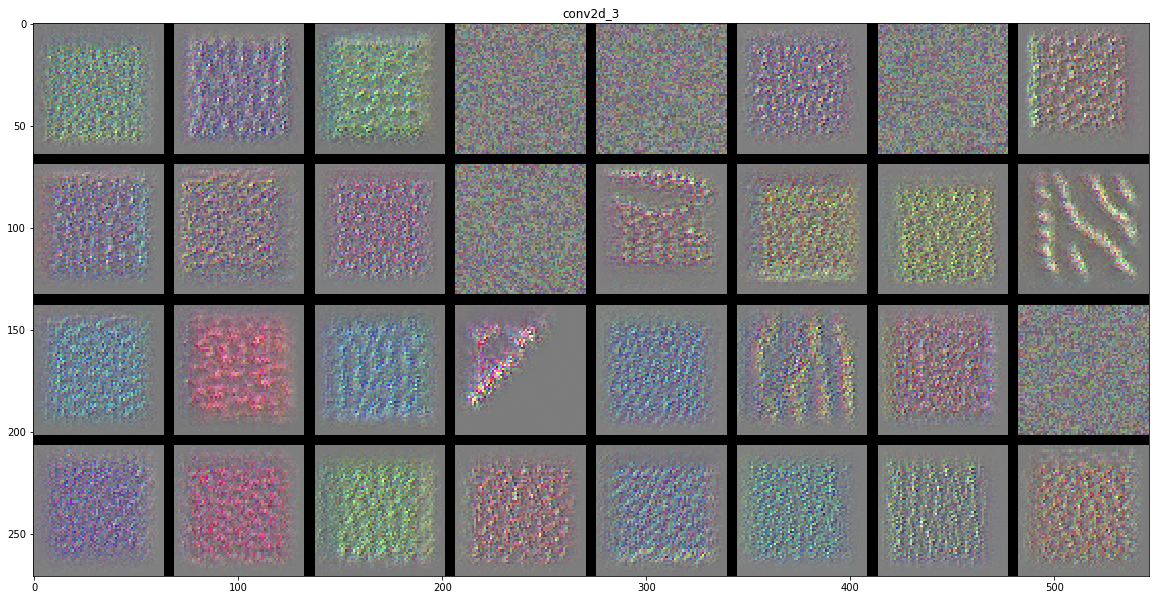

 75%|███████▌  | 3/4 [01:12<00:24, 24.91s/it]

conv2d_4 0 432.61615
conv2d_4 1 0.0
conv2d_4 2 0.0
conv2d_4 3 0.0
conv2d_4 4 0.0
conv2d_4 5 463.7882
conv2d_4 6 0.0
conv2d_4 7 0.0
conv2d_4 8 285.77258
conv2d_4 9 238.44398
conv2d_4 10 0.0
conv2d_4 11 523.1084
conv2d_4 12 0.0
conv2d_4 13 0.0
conv2d_4 14 269.35394
conv2d_4 15 0.0
conv2d_4 16 421.58868
conv2d_4 17 0.0
conv2d_4 18 0.0
conv2d_4 19 220.72318
conv2d_4 20 384.21494
conv2d_4 21 0.0
conv2d_4 22 0.0
conv2d_4 23 323.239
conv2d_4 24 0.0
conv2d_4 25 323.95163
conv2d_4 26 0.0
conv2d_4 27 328.0852
conv2d_4 28 489.2825
conv2d_4 29 0.0
conv2d_4 30 361.55902
conv2d_4 31 0.0


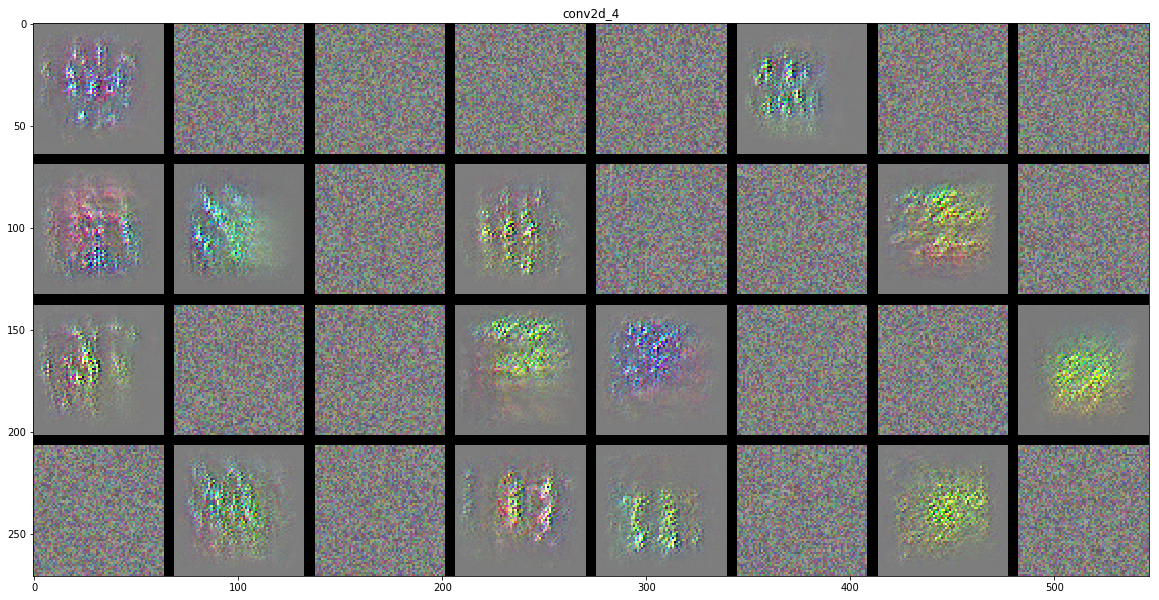

100%|██████████| 4/4 [01:38<00:00, 25.12s/it]


In [18]:
for layer_name in tqdm(layer_names):
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((4 * size + 3 * margin, 8 * size + 7 * margin, 3))

    for i in range(4):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, j + (i * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.title(layer_name)

    plt.imshow(results)
    plt.show()